STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p matplotlib,torch,pandas,numpy

Sebastian Raschka 

CPython 3.7.1
IPython 7.12.0

matplotlib 3.1.0
torch 1.4.0
pandas 1.0.1
numpy 1.18.1


---

# Solving the XOR Problem

## Toy Dataset

In [2]:
import torch
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 123
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv('xor.csv')
X = df[['x1', 'x2']].values
y = df['class label'].values

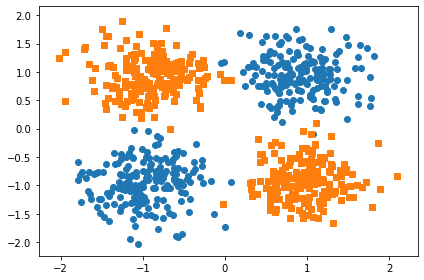

In [4]:
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o')
plt.scatter(X[y==1, 0], X[y==1, 1], marker='s')

plt.tight_layout()
#plt.savefig('xor.pdf')
plt.show()

## Multilayer Perceptron with Linear Activations

In [5]:
class MLPLinear(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPLinear, self).__init__()
        
        self.num_classes = num_classes
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        out = self.linear_1(x)
        #out = F.relu(out)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [6]:
torch.manual_seed(RANDOM_SEED)

model1 = MLPLinear(num_features=2,
                   num_hidden_1=50,
                   num_classes=2)

model1 = model1.to(DEVICE)

optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

In [7]:
start_time = time.time()
minibatch_cost = []

NUM_EPOCHS = 25

features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets = torch.tensor(y, dtype=torch.long).to(DEVICE)

for epoch in range(NUM_EPOCHS):

    ### FORWARD AND BACK PROP
    logits, probas = model1(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()
    minibatch_cost.append(cost)
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    ### LOGGING

    print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Cost: {cost:.4f}')

    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Cost: 0.7075
Epoch: 002/025 | Cost: 0.6980
Epoch: 003/025 | Cost: 0.6946
Epoch: 004/025 | Cost: 0.6933
Epoch: 005/025 | Cost: 0.6929
Epoch: 006/025 | Cost: 0.6928
Epoch: 007/025 | Cost: 0.6927
Epoch: 008/025 | Cost: 0.6927
Epoch: 009/025 | Cost: 0.6927
Epoch: 010/025 | Cost: 0.6927
Epoch: 011/025 | Cost: 0.6927
Epoch: 012/025 | Cost: 0.6927
Epoch: 013/025 | Cost: 0.6927
Epoch: 014/025 | Cost: 0.6927
Epoch: 015/025 | Cost: 0.6927
Epoch: 016/025 | Cost: 0.6927
Epoch: 017/025 | Cost: 0.6927
Epoch: 018/025 | Cost: 0.6927
Epoch: 019/025 | Cost: 0.6927
Epoch: 020/025 | Cost: 0.6927
Epoch: 021/025 | Cost: 0.6927
Epoch: 022/025 | Cost: 0.6927
Epoch: 023/025 | Cost: 0.6927
Epoch: 024/025 | Cost: 0.6927
Epoch: 025/025 | Cost: 0.6927
Total Training Time: 0.00 min


In [8]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

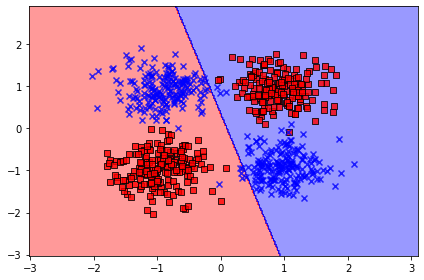

In [9]:
plot_decision_regions(features, targets, classifier=model1)

plt.tight_layout()
#plt.savefig('xor1.pdf')
plt.show()

<br>
<br>

## Multilayer Perceptron with Non-Linear Activations (Here: ReLU)

In [10]:
class MLPReLU(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPReLU, self).__init__()
        
        self.num_classes = num_classes
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        out = self.linear_1(x)
        out = F.relu(out)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [11]:
torch.manual_seed(RANDOM_SEED)

model2 = MLPReLU(num_features=2,
                num_hidden_1=50,
                num_classes=2)

model2 = model2.to(DEVICE)

optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [12]:
start_time = time.time()
minibatch_cost = []

NUM_EPOCHS = 25

features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets = torch.tensor(y, dtype=torch.long).to(DEVICE)

for epoch in range(NUM_EPOCHS):

    ### FORWARD AND BACK PROP
    logits, probas = model2(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()
    minibatch_cost.append(cost)
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    ### LOGGING

    print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Cost: {cost:.4f}')

    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Cost: 0.7163
Epoch: 002/025 | Cost: 0.6874
Epoch: 003/025 | Cost: 0.6631
Epoch: 004/025 | Cost: 0.6412
Epoch: 005/025 | Cost: 0.6210
Epoch: 006/025 | Cost: 0.6019
Epoch: 007/025 | Cost: 0.5838
Epoch: 008/025 | Cost: 0.5665
Epoch: 009/025 | Cost: 0.5501
Epoch: 010/025 | Cost: 0.5344
Epoch: 011/025 | Cost: 0.5193
Epoch: 012/025 | Cost: 0.5049
Epoch: 013/025 | Cost: 0.4910
Epoch: 014/025 | Cost: 0.4777
Epoch: 015/025 | Cost: 0.4649
Epoch: 016/025 | Cost: 0.4525
Epoch: 017/025 | Cost: 0.4406
Epoch: 018/025 | Cost: 0.4291
Epoch: 019/025 | Cost: 0.4181
Epoch: 020/025 | Cost: 0.4074
Epoch: 021/025 | Cost: 0.3971
Epoch: 022/025 | Cost: 0.3872
Epoch: 023/025 | Cost: 0.3776
Epoch: 024/025 | Cost: 0.3684
Epoch: 025/025 | Cost: 0.3594
Total Training Time: 0.00 min


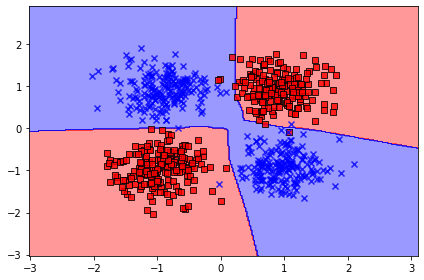

In [13]:
plot_decision_regions(features, targets, classifier=model2)

plt.tight_layout()
#plt.savefig('xor2.pdf')
plt.show()